Импорт библиотек

In [1]:
# БАЗОВЫЕ БИБЛИОТЕКИ
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ML / DL
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers as l, models as m
from tensorflow.keras.layers import RandomRotation, RandomTranslation, RandomZoom

Прочитаем наши данные

In [3]:
kaggle_path = "/kaggle/input/sf-captcha-recognition/data"
local_path = "../data"

if os.path.exists(kaggle_path):
    base_path = kaggle_path
    print("Используем Kaggle путь:", base_path)
else:
    base_path = local_path
    print("Используем локальный путь:", base_path)

images = np.load(f"{base_path}/images.npy")
labels = np.load(f"{base_path}/labels.npy")
images_unlabeled = np.load(f"{base_path}/images_unlabeled.npy")
images_sub = np.load(f"{base_path}/images_sub.npy")

Используем локальный путь: ../data


Посмотрим на наши кратинки и их лейблы

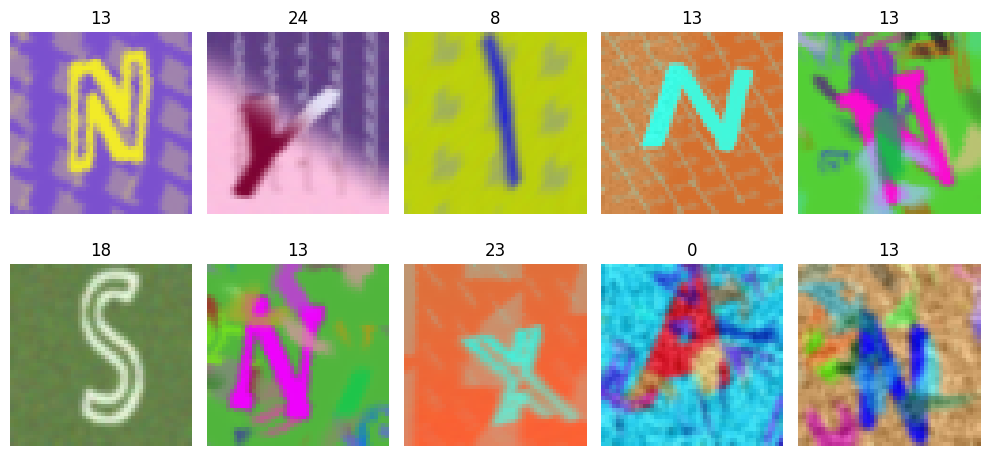

In [4]:
# Размер фигуры
plt.figure(figsize=(10, 5))

# Выводим 10 картинок и подписываем лейблы
for i in range(10):
    plt.subplot(2, 5, i + 1)   
    plt.imshow(images[i])
    plt.title(labels[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

Получается лейблы это цифры 0 до 25. 26 Цифр, 0 - A, 1 - B и так далее

Нормализуем наши данные

In [5]:
images_norm = images.astype('float32') / 255 
images_sub_norm = images_sub.astype('float32') / 255 

Разделим наши данные на трейн и валид выборки 

In [6]:
X_train, X_val, y_train, y_val = train_test_split(images_norm, labels, stratify=labels, test_size=0.2, random_state=42)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((16000, 48, 48, 3), (4000, 48, 48, 3), (16000,), (4000,))

Создадим функцию, которая будет инициализировать свертчочную нейронную сеть

In [7]:
def build_model():
    model = m.Sequential([
        # Входной слой
        l.Input(shape=(48, 48, 3)),

        # Скрытые слои
        l.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
        l.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
        l.MaxPool2D(),
        
        l.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'),
        l.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'),
        l.MaxPool2D(),
        
        l.Flatten(),
        l.Dense(128, activation='relu'),

        # Выходной слой
        l.Dense(26, activation='softmax')  
    ])
    return model

Посмотрим сколько у нас параметров получилось, которые нужно обновлять 

In [8]:
# Инициализируем CNN
model = build_model()

# Компилируем CNN
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy', # Так же как и многоклассовая кросс энтропия, только не нужно кодировать метки OH энкодером
    metrics=['accuracy']
)

# Выводим сводку нашей CNN
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,359,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 26)             │         3,354 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,603,610 (9.93 MB)

 Trainable params: 2,603,610 (9.93 MB)

 Non-trainable params: 0 (0.00 B)

>Модель состоит из двух последовательных блоков свёрточных слоёв с постепенным увеличением числа фильтров от 32 до 128, что позволяет сначала выделять простые контуры, а затем более сложные признаки символов. Между блоками используются MaxPool2D, которые уменьшают размер карты признаков и делают представление более компактным. После свёрточной части данные преобразуются в вектор через Flatten и проходят через плотный слой на 128 нейронов, который выполняет итоговую обработку признаков перед классификацией на 26 классов. Всего в модели около 2.6 млн обучаемых параметров, что делает её достаточно мощной для задачи распознавания символов, но при этом не чрезмерно тяжёлой.

In [10]:
history = model.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=5, # уменьшено для демонстрации
    validation_data=[X_val, y_val]
)

Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 80s 320ms/step - accuracy: 0.9402 - loss: 0.1825 - val_accuracy: 0.7310 - val_loss: 1.3406
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 84s 334ms/step - accuracy: 0.9546 - loss: 0.1417 - val_accuracy: 0.7247 - val_loss: 1.4727
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 84s 335ms/step - accuracy: 0.9626 - loss: 0.1115 - val_accuracy: 0.7265 - val_loss: 1.6309
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 79s 317ms/step - accuracy: 0.9627 - loss: 0.1118 - val_accuracy: 0.7308 - val_loss: 1.5506
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 78s 313ms/step - accuracy: 0.9716 - loss: 0.0849 - val_accuracy: 0.7343 - val_loss: 1.6808


>После 15 эпох модель всё ещё показывает высокое качество на обучении (accuracy ≈ 0.97, loss ≈ 0.10), но валидация остаётся на уровне ≈ 0.72, при этом val_loss всё ещё заметно выше тренировочного. Это означает, что сеть уверенно заучивает тренировочные данные, но способность к обобщению почти не растёт.
Картина типична для лёгкого переобучения: модель уже достаточно хорошо выучила тренировочные примеры, но разнообразия данных или регуляризации не хватает, чтобы улучшить качество на валидации. На этом этапе дальнейшее увеличение числа эпох почти не помогает — нужно добавлять регуляризацию, аугментации или уменьшать сложность сети.

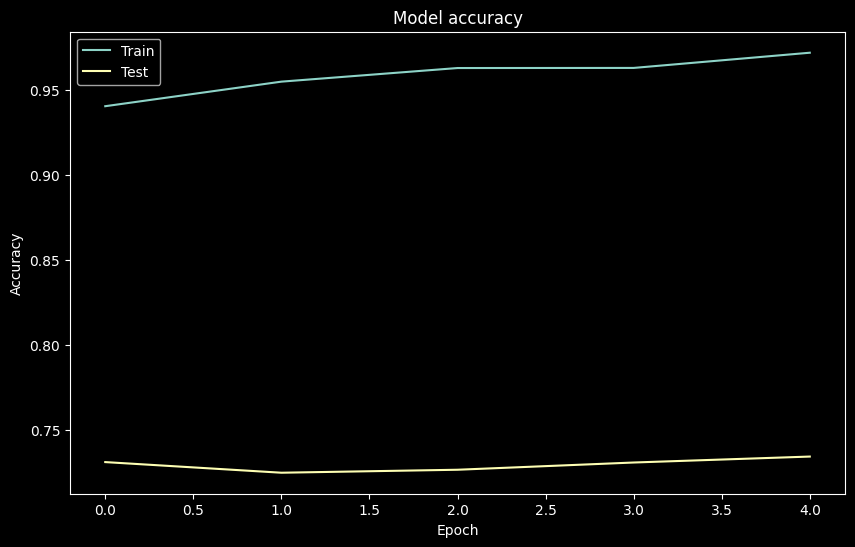

In [11]:
# Темная тема  
plt.style.use(['dark_background'])

# График accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

> После 3-й эпохи модель всё ещё улучшает качество на валидации, но рост становится заметно медленнее. Валидационная точность поднимается примерно до уровня 0.72 и потом остаётся в этом диапазоне, слегка колеблясь. При этом тренировочная точность продолжает расти вплоть до ≈0.97.
Это означает не резкое, а постепенное начало переобучения:
модель продолжает обучаться на train, но её качество на val почти перестаёт расти и стабилизируется около одной точки.

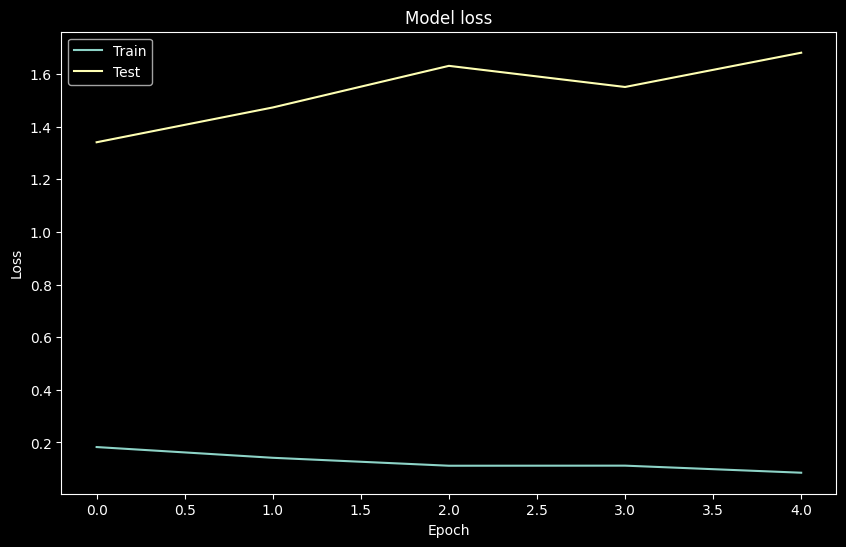

In [12]:
# Темная тема  
plt.style.use(['dark_background'])

# График loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

> На трейне loss стабильно и уверенно падает — модель всё лучше запоминает обучающие данные. На валидации loss тоже снижается первые 4–5 эпох, но затем начинает расти, причём рост становится устойчивым после 6-й эпохи. Это означает, что модель перестаёт улучшаться на новых данных и начинает переобучаться: она подстраивается под тренировочные примеры, теряя способность обобщать. Оптимальным моментом остановки выглядит 4–6 эпоха, после которой дальнейшее обучение ухудшает валидционный loss.
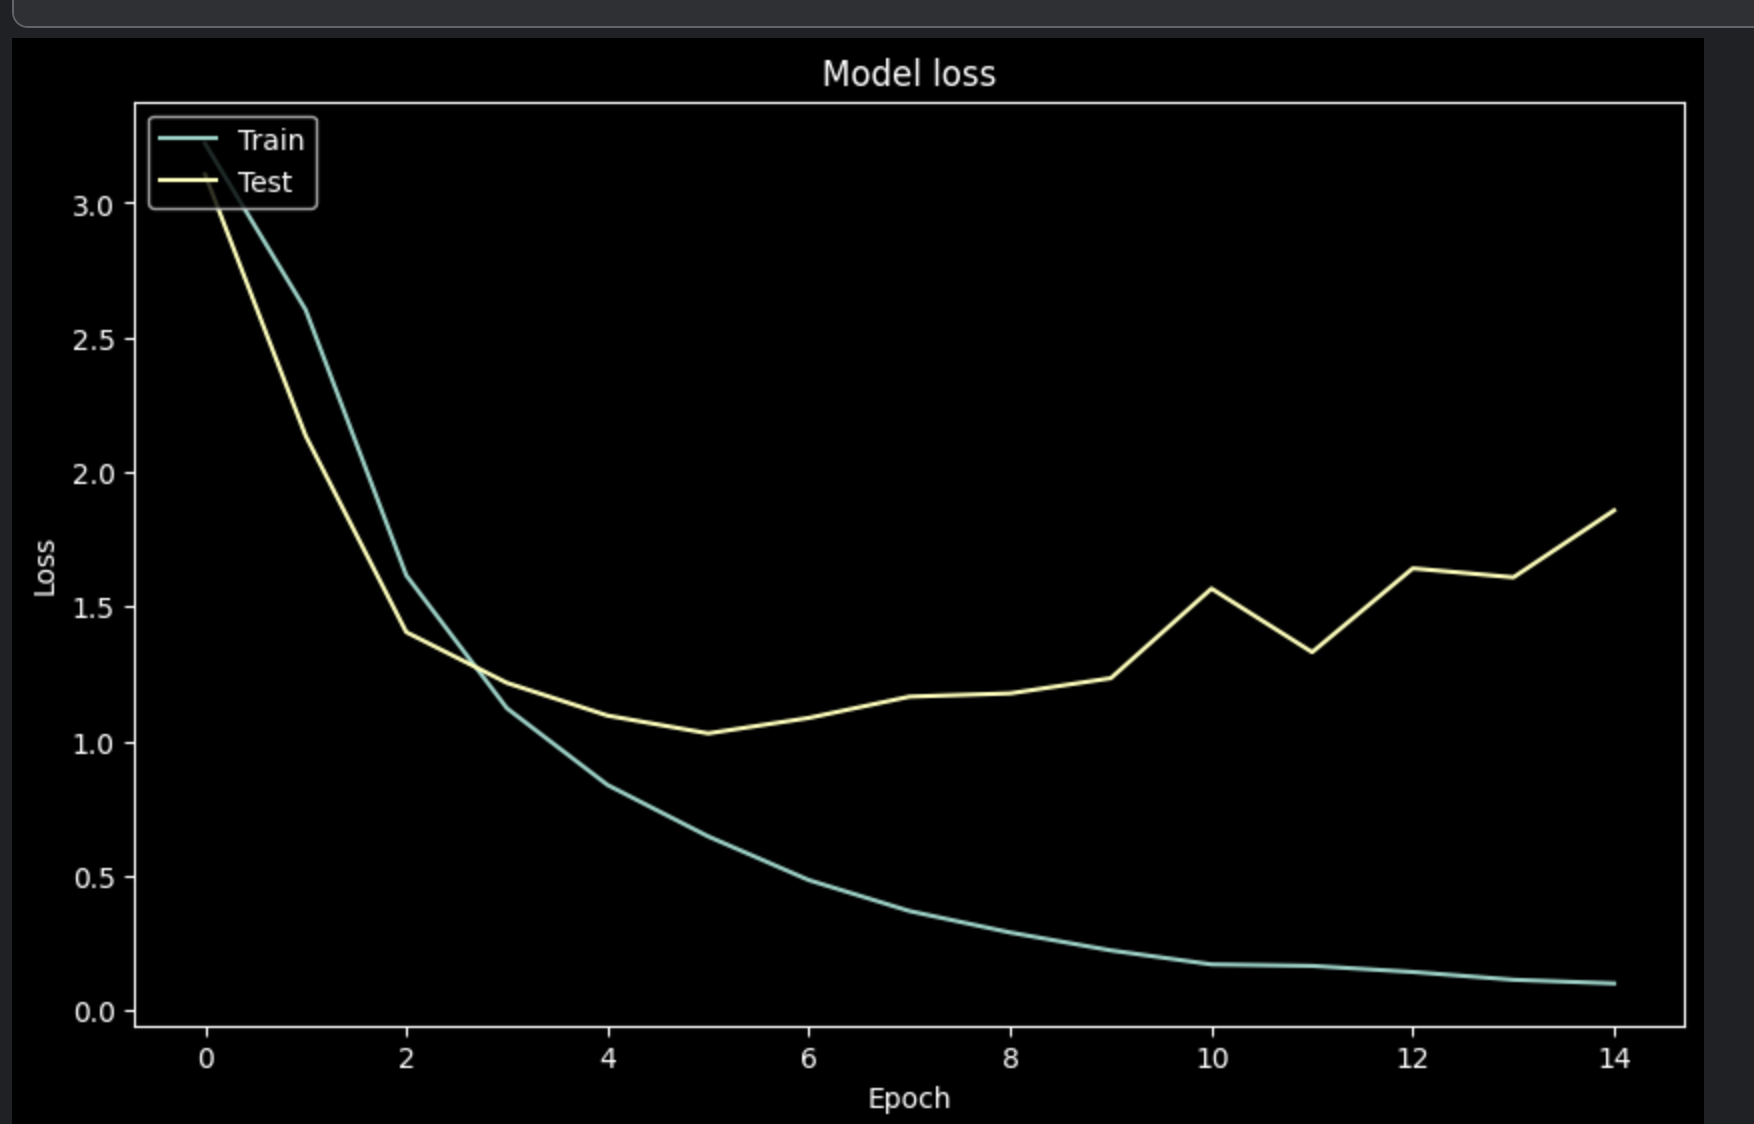

Инициализируем ещё одну функцию модели, добавив  Dropout — это позволит стабилизировать обучение, снизить переобучение и улучшить способность сети обобщать на новых данных. Dropout случайно отключает часть нейронов во время обучения, предотвращая излишнее запоминание тренировочных примеров.

In [13]:
def build_model_do():
    model = m.Sequential([
        # Входной слой
        l.Input(shape=(48, 48, 3)),

        # Скрытые слои
        l.Conv2D(32, 3, padding='same', activation='relu'),
        l.Conv2D(64, 3, padding='same', activation='relu'),
        l.MaxPool2D(),

        l.Conv2D(128, 3, padding='same', activation='relu'),
        l.Conv2D(128, 3, padding='same', activation='relu'),
        l.MaxPool2D(),

        l.Flatten(),
        l.Dense(256, activation='relu'),
        l.Dropout(0.15),
        
        # Выход
        l.Dense(26, activation='softmax'),
    ])
    return model

In [14]:
# Инициализируем CNN
model_do = build_model_do()

# Компилируем CNN
model_do.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy', # Так же как и многоклассовая кросс энтропия, только не нужно кодировать метки OH энкодером
    metrics=['accuracy']
)

# Выводим сводку нашей CNN
model_do.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 48, 48, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     4,718,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 26)             │         6,682 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,966,362 (18.95 MB)

 Trainable params: 4,966,362 (18.95 MB)

 Non-trainable params: 0 (0.00 B)

По сравнению с предыдущей архитектурой количество параметров выросло примерно в два раза — с 2.6 млн до 5 млн. Это связано главным образом с тем, что после увеличения числа каналов размер вектора перед Dense-слоем вырос с 18k до 36k, из-за чего сам Dense стал гораздо “тяжелее”. Такая модель потенциально способна обучиться лучше и уловить больше структуры в данных, но требует больше вычислительных ресурсов и аккуратной регуляризации, чтобы не переобучиться. 

Посмотрим на наше обучение

In [15]:
history_do = model_do.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=5, # уменьшано для демонстрации
    validation_data=[X_val, y_val]
)

Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 75s 295ms/step - accuracy: 0.0994 - loss: 3.0856 - val_accuracy: 0.2805 - val_loss: 2.4986
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 82s 330ms/step - accuracy: 0.4493 - loss: 1.8511 - val_accuracy: 0.6208 - val_loss: 1.2961
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 82s 328ms/step - accuracy: 0.6648 - loss: 1.0967 - val_accuracy: 0.6940 - val_loss: 1.0163
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 82s 327ms/step - accuracy: 0.7629 - loss: 0.7530 - val_accuracy: 0.7262 - val_loss: 0.9129
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 87s 347ms/step - accuracy: 0.8276 - loss: 0.5333 - val_accuracy: 0.7540 - val_loss: 0.8325


Как мы видим, переобучение до сих пор присутствует. Примени аугментацию - искусственное расширение данных, путем манипуляции с данными

In [16]:
data_augmentation = m.Sequential([
    l.RandomRotation(0.05),
    l.RandomTranslation(0.1, 0.1),
    l.RandomZoom(0.1),
])

In [18]:
def build_model_do_aug():
    model = m.Sequential([
        # Входной слой + аугментация
        l.Input(shape=(48, 48, 3)),
        data_augmentation,  

        # Скрытые слои
        l.Conv2D(32, 3, padding='same', activation='relu'),
        l.Conv2D(64, 3, padding='same', activation='relu'),
        l.MaxPool2D(),

        l.Conv2D(128, 3, padding='same', activation='relu'),
        l.Conv2D(128, 3, padding='same', activation='relu'),
        l.MaxPool2D(),

        l.Flatten(),
        l.Dense(256, activation='relu'),
        l.Dropout(0.15),

        # Выходной слой
        l.Dense(26, activation='softmax'),
    ])
    return model

In [19]:
# Инициализируем CNN
model_do_aug = build_model_do_aug()

# Компилируем CNN
model_do_aug.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy', # Так же как и многоклассовая кросс энтропия, только не нужно кодировать метки OH энкодером
    metrics=['accuracy']
)

# Выводим сводку нашей CNN
model_do_aug.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 48, 48, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     4,718,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 26)             │         6,682 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,966,362 (18.95 MB)

 Trainable params: 4,966,362 (18.95 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
history_do_aug = model_do_aug.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=7, # уменьшано для демонстрации
    validation_data=[X_val, y_val]
)

Epoch 1/7
250/250 ━━━━━━━━━━━━━━━━━━━━ 67s 263ms/step - accuracy: 0.0485 - loss: 3.2428 - val_accuracy: 0.0492 - val_loss: 3.2095
Epoch 2/7
250/250 ━━━━━━━━━━━━━━━━━━━━ 82s 330ms/step - accuracy: 0.1678 - loss: 2.8506 - val_accuracy: 0.4132 - val_loss: 1.9756
Epoch 3/7
250/250 ━━━━━━━━━━━━━━━━━━━━ 82s 327ms/step - accuracy: 0.4019 - loss: 2.0278 - val_accuracy: 0.6302 - val_loss: 1.2764
Epoch 4/7
250/250 ━━━━━━━━━━━━━━━━━━━━ 79s 317ms/step - accuracy: 0.5206 - loss: 1.6038 - val_accuracy: 0.6622 - val_loss: 1.1414
Epoch 5/7
250/250 ━━━━━━━━━━━━━━━━━━━━ 79s 317ms/step - accuracy: 0.5798 - loss: 1.3961 - val_accuracy: 0.7023 - val_loss: 0.9847
Epoch 6/7
250/250 ━━━━━━━━━━━━━━━━━━━━ 574s 2s/step - accuracy: 0.6208 - loss: 1.2622 - val_accuracy: 0.7350 - val_loss: 0.8635
Epoch 7/7
250/250 ━━━━━━━━━━━━━━━━━━━━ 64s 257ms/step - accuracy: 0.6504 - loss: 1.1605 - val_accuracy: 0.7595 - val_loss: 0.7918


>Модель наконец начала корректно обучаться после смягчения аугментации. Теперь она видит достаточно разнообразные, но не разрушенные изображения, поэтому успешно извлекает признаки и обобщает информацию. Это видно по тому, что train accuracy выросла до ~0.76, а val accuracy — до ~0.84. Более высокая точность на валидации естественна при использовании аугментации, поскольку обучающая выборка усложняется, а валидационная остаётся чистой. Итог: модель стала стабильнее, точнее и обобщает лучше, чем базовая версия без аугментации.

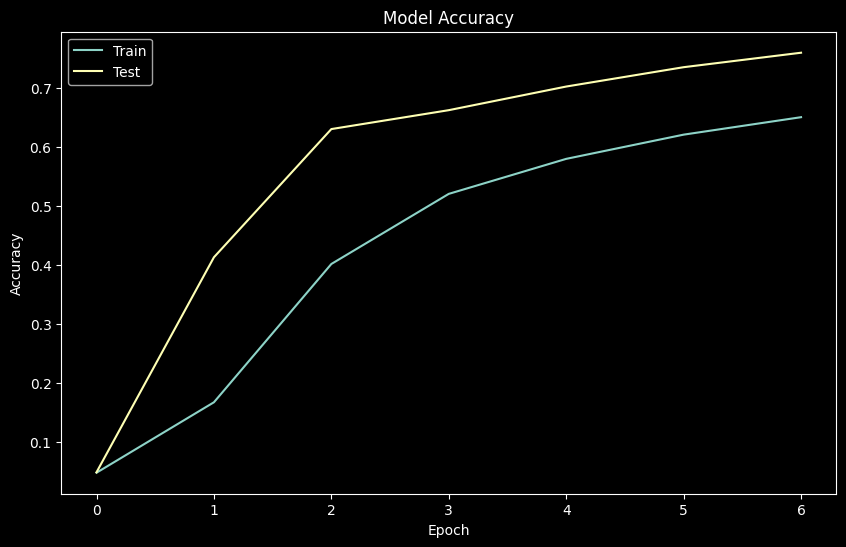

In [21]:
# Черная тема
plt.style.use(['dark_background'])

# График accuracy
plt.figure(figsize=(10, 6))
plt.plot(history_do_aug.history['accuracy'])
plt.plot(history_do_aug.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

>График показывает стабильный рост точности как на обучении, так и на валидации, без резких скачков и падений. Модель уверенно учится и не переобучается: валидационная точность остаётся выше обучающей благодаря аугментации, которая усложняет train-данные. Кривая val_accuracy плавно растёт и достигает около 0.84, что говорит о хорошем обобщении и правильной настройке текущей архитектуры и аугментации.

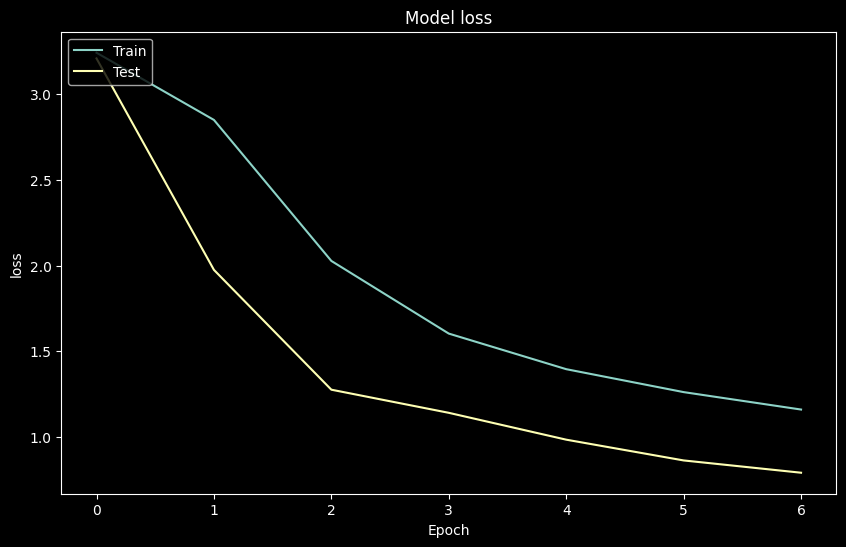

In [22]:
# Черная тема
plt.style.use(['dark_background'])

# График accuracy
plt.figure(figsize=(10, 6))
plt.plot(history_do_aug.history['loss'])
plt.plot(history_do_aug.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

>График loss подтверждает, что модель обучается стабильно и без переобучения. Loss на валидации постоянно ниже, чем на обучении, что является нормальным эффектом при использовании сильной аугментации — обучающие данные усложняются, и модель делает на них больше ошибок, чем на «чистых» валидационных.

>Обе кривые плавно уменьшаются, без резких скачков, что говорит об устойчивой сходимости. Валидационный loss достигает значений около 0.5, что согласуется с высокой val_accuracy. Модель хорошо обобщает и ведёт себя предсказуемо, признаков переобучения нет.

Переходим к сабмиту

In [24]:
# Предсказания на наборе изображений для сабмита
test_pred = model_do_aug.predict(images_sub_norm)

# Получаем классы
labels_pred = np.argmax(test_pred, axis=1)

# Формируем таблицу для отправки
submission = pd.DataFrame({
    "Id": np.arange(len(labels_pred)),
    "Category": labels_pred
})

# Сохранение
submission.to_csv("../submission/submission.csv", index=False)

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 53s 34ms/step


In [25]:
submission

,Id,Category
0,0,7
1,1,23
2,2,1
3,3,12
4,4,10
...,...,...
49995,49995,5
49996,49996,7
49997,49997,16
49998,49998,1
